In [1]:
import numpy as np
from vpsto.vpsto import VPSTO, VPSTOOptions, VPSTOSolution
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, MultiPolygon, LineString

In [2]:
# Define some polygons for creating a collision environment
class CollisionEnvironment():
    def __init__(self):
        self.poly_list = []
        self.poly_list.append(np.array([[0.1, 0.13], [0.23, 0.12], [0.19, 0.28], [0.1, 0.32], [0.16, 0.2]]))
        self.poly_list.append(np.array([[0.25, 0.34], [0.31, 0.35], [0.32, 0.41], [0.27, 0.44], [0.23, 0.4]]))
        self.poly_list.append(np.array([[0.35, 0.12], [0.38, 0.1], [0.41, 0.11], [0.42, 0.21], [0.35, 0.24]]))
        self.multi_poly = MultiPolygon([Polygon(self.poly_list[0]), Polygon(self.poly_list[1]), Polygon(self.poly_list[2])])
        
    def getTrajDist(self, pts):
        return self.multi_poly.intersection(LineString(pts)).length

In [3]:
q_min = 0.0*np.ones(2)
q_max = 0.5*np.ones(2)
def loss_limits(candidates):
    q = candidates['pos']
    d_min = np.maximum(np.zeros_like(q), - q + q_min)
    d_max = np.maximum(np.zeros_like(q), q - q_max)
    return np.sum(d_min > 0.0, axis=(1,2)) + np.sum(d_max > 0.0, axis=(1,2))

env = CollisionEnvironment()
def loss_collision(candidates): 
    costs = []
    for traj in candidates['pos']:
        costs.append(env.getTrajDist(traj))
    costs = np.array(costs)
    costs += costs > 0.0
    return costs

def loss_curvature(candidates):
    dq = candidates['vel']
    ddq = candidates['acc']
    dq_sq = np.sum(dq**2, axis=-1)
    ddq_sq = np.sum(ddq**2, axis=-1)
    dq_ddq = np.sum(dq*ddq, axis=-1) 
    return np.mean((dq_sq * ddq_sq - dq_ddq**2) / (dq_sq**3 + 1e-6), axis=-1)

def loss(candidates):
    cost_curvature = loss_curvature(candidates)
    cost_collision = loss_collision(candidates)
    cost_limits = loss_limits(candidates)
    return candidates['T'] + 1e-3 * cost_curvature + 1e3 * cost_collision + 1e3 * cost_limits

In [4]:
# traj_opt = VPSTO(ndof=2)

# traj_opt.opt.N_via = 5
# traj_opt.opt.vel_lim = np.array([0.1, 0.1])
# traj_opt.opt.acc_lim = np.array([0.5, 0.5])
# traj_opt.opt.max_iter = 200

In [29]:
opt = VPSTOOptions(ndof=2)
opt.N_via = 2
opt.N_eval = 200
opt.pop_size = 500
opt.log = True

In [30]:
traj_opt = VPSTO(opt)
traj_opt.ndof = 2
traj_opt.vel_lim = np.array([0.1, 0.1])
traj_opt.acc_lim = np.array([0.5, 0.5])

In [36]:
q0 = np.array([0.1, 0.2]) # robot position
qd = np.array([0.4, 0.3])  # desired robot position

dq0 = np.array([0.1, 0.1])
dqT = np.array([0, 0])

In [37]:
sol = traj_opt.minimize(loss, q0=q0, qT=qd, dq0=dq0, dqT=dqT)

t_traj = np.linspace(0, sol.T_best, 1000)
# pos, vel, acc = sol.get_trajectory(t_traj)
pos, vel, acc = sol.get_posvelacc(t_traj)

print('Movement duration: ', sol.T_best)

VP-STO finished after 55 iterations with a final loss of 1058.572535500583
Movement duration:  5.252403063521814


In [46]:
len(sol.candidates['pos'])

500

In [57]:
traj_test = sol.candidates['pos'][0]
traj_test

array([[0.1       , 0.2       ],
       [0.1026021 , 0.20262907],
       [0.1051305 , 0.20523745],
       [0.10758649, 0.20782505],
       [0.10997139, 0.21039177],
       [0.11228649, 0.2129375 ],
       [0.11453308, 0.21546214],
       [0.11671246, 0.21796559],
       [0.11882593, 0.22044776],
       [0.12087478, 0.22290854],
       [0.12286032, 0.22534784],
       [0.12478385, 0.22776554],
       [0.12664665, 0.23016156],
       [0.12845004, 0.23253578],
       [0.1301953 , 0.23488812],
       [0.13188373, 0.23721846],
       [0.13351663, 0.23952672],
       [0.13509531, 0.24181278],
       [0.13662105, 0.24407655],
       [0.13809516, 0.24631793],
       [0.13951892, 0.24853682],
       [0.14089365, 0.25073311],
       [0.14222064, 0.25290671],
       [0.14350118, 0.25505752],
       [0.14473658, 0.25718543],
       [0.14592813, 0.25929034],
       [0.14707713, 0.26137216],
       [0.14818487, 0.26343078],
       [0.14925266, 0.26546611],
       [0.15028179, 0.26747804],
       [0.

In [58]:
obs_x = np.array([40, 60])
obs_y = np.array([-20, 0])
obs_a = 5
obs_b = 1.5

In [59]:
traj_x = traj_test[:, 0]
traj_y = traj_test[:, 1]

In [62]:
cost_coll = ((traj_x - obs_x[:, np.newaxis])/((2*obs_a))**2) - ((traj_y - obs_y[:, np.newaxis])/(2*obs_b)**2) + 1

In [71]:
cost_coll

array([[-1.64344444, -1.64371054, -1.64397508, -1.64423803, -1.64449937,
        -1.64475908, -1.64501713, -1.6452735 , -1.64552816, -1.64578109,
        -1.64603227, -1.64628167, -1.64652926, -1.64677503, -1.64701895,
        -1.64726099, -1.64750114, -1.64773936, -1.64797563, -1.64820993,
        -1.64844224, -1.64867252, -1.64890076, -1.64912693, -1.64935101,
        -1.64957298, -1.6497928 , -1.65001046, -1.65022593, -1.65043919,
        -1.65065021, -1.65085896, -1.65106544, -1.6512696 , -1.65147143,
        -1.6516709 , -1.65186799, -1.65206267, -1.65225492, -1.65244472,
        -1.65263204, -1.65281685, -1.65299914, -1.65317888, -1.65335604,
        -1.65353061, -1.65370255, -1.65387184, -1.65403846, -1.65420239,
        -1.65436359, -1.65452205, -1.65467774, -1.65483064, -1.65498072,
        -1.65512797, -1.65527234, -1.65541383, -1.65555241, -1.65568804,
        -1.65582072, -1.65595041, -1.65607709, -1.65620074, -1.65632133,
        -1.65643883, -1.65655323, -1.6566645 , -1.6

In [68]:
effective_cost_coll = np.sum(cost_coll, axis=0)

In [72]:
effective_cost_coll

array([-1.26466667, -1.26519886, -1.26572794, -1.26625384, -1.26677652,
       -1.26729594, -1.26781204, -1.26832477, -1.2688341 , -1.26933996,
       -1.26984231, -1.27034111, -1.2708363 , -1.27132784, -1.27181568,
       -1.27229976, -1.27278005, -1.27325649, -1.27372904, -1.27419764,
       -1.27466225, -1.27512282, -1.2755793 , -1.27603165, -1.27647981,
       -1.27692374, -1.27736338, -1.2777987 , -1.27822964, -1.27865615,
       -1.27907819, -1.2794957 , -1.27990865, -1.28031697, -1.28072063,
       -1.28111957, -1.28151375, -1.28190312, -1.28228762, -1.28266722,
       -1.28304185, -1.28341149, -1.28377606, -1.28413554, -1.28448987,
       -1.28483899, -1.28518287, -1.28552146, -1.2858547 , -1.28618255,
       -1.28650496, -1.28682188, -1.28713326, -1.28743906, -1.28773923,
       -1.28803371, -1.28832247, -1.28860544, -1.28888259, -1.28915387,
       -1.28941922, -1.2896786 , -1.28993196, -1.29017925, -1.29042043,
       -1.29065544, -1.29088424, -1.29110678, -1.29132301, -1.29

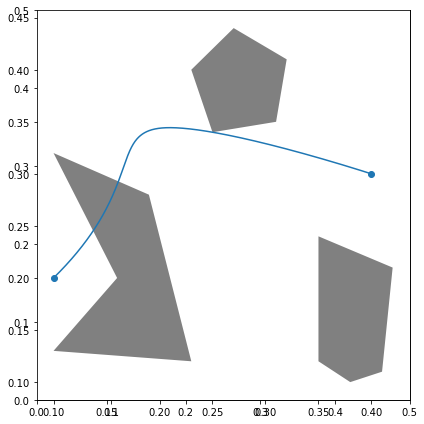

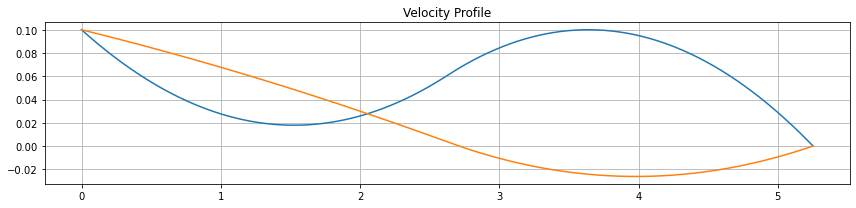

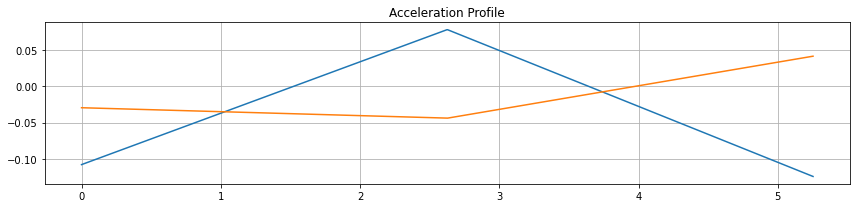

In [38]:
plt.figure(figsize=(6,6))

plt.xlim([q_min[0], q_max[0]])
plt.ylim([q_min[1], q_max[1]])
ax = plt.axes()

plt.scatter([q0[0], qd[0]],[q0[1], qd[1]])
for pol in env.poly_list:
    ax.add_patch(patches.Polygon(pol, facecolor = 'gray'))

plt.plot(pos[:,0], pos[:,1])
plt.tight_layout()

plt.figure(figsize=(12, 3))
plt.grid()
plt.title('Velocity Profile')
plt.plot(t_traj, vel)
plt.tight_layout()

plt.figure(figsize=(12, 3))
plt.grid()
plt.title('Acceleration Profile')
plt.plot(t_traj, acc)
plt.tight_layout()